# Data Science Project: Planning Report
### Group Project 003 32 Jeffrey Deng

### Introduction
This project analyzes data collected from a Minecraft research server run by a UBC Computer Science group (Frank Wood). The dataset comprises two linked tables: players.csv (one row per player with profile and demographics) and sessions.csv (one row per play session with timestamps). These logs were gathered to support real operational needs—targeting recruitment and planning server capacity.

### Broad Question
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Specific Question
Can a player’s experience level, total played hours, age, and gender predict whether they subscribe to the newsletter?

### Response and Explanatory Variables
- Response variable: `subscribe` (binary) from `players.csv`.
- Explanatory variables: `experience` (categorical), `played_hours` (numeric), `Age` (numeric), `gender` (categorical) from `players.csv`.

### Dataset Overview
- `players.csv`：196 rows × 7 columns (one row per player)
- `sessions.csv`：1535 rows × 5 columns (one row per session)


## Data Description: Players

In [2]:
library(tidyverse)
players <- read_csv("data/players.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
glimpse(players)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


### Summary of Players Dataset

In [4]:
missing_tbl <- players |>
  summarise(across(everything(), ~ sum(is.na(.)))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "missing_count")

type_of <- function(x) class(x)[1]

players_dict <- tibble(
  variable = names(players),
  type     = purrr::map_chr(players, type_of),
  description = dplyr::case_when(
    variable == "experience"   ~ "Player experience level (Beginner/Amateur/Regular/Veteran/Pro)",
    variable == "subscribe"    ~ "Newsletter subscription (TRUE/FALSE)",
    variable == "hashedEmail"  ~ "Hashed email (join key to sessions)",
    variable == "played_hours" ~ "Total played hours (numeric)",
    variable == "name"         ~ "Player display name (string)",
    variable == "gender"       ~ "Gender/identity label (categorical)",
    variable == "Age"          ~ "Age (years, numeric)",
    TRUE ~ ""
  )
) |>
  left_join(missing_tbl, by = "variable") |>
  arrange(variable)

players_dict

variable,type,description,missing_count
<chr>,<chr>,<chr>,<int>
Age,numeric,"Age (years, numeric)",2
experience,character,Player experience level (Beginner/Amateur/Regular/Veteran/Pro),0
gender,character,Gender/identity label (categorical),0
hashedEmail,character,Hashed email (join key to sessions),0
name,character,Player display name (string),0
played_hours,numeric,Total played hours (numeric),0
subscribe,logical,Newsletter subscription (TRUE/FALSE),0


### Player Means
  - `played_hours` — **5.85** hours (mean)
  - `Age` — **21.14** years (mean)

In [5]:
players_means <- players |>
  select(where(is.numeric)) |>
  summarise(across(everything(), ~ round(mean(.x, na.rm = TRUE), 2))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "mean_2dp")

players_means


variable,mean_2dp
<chr>,<dbl>
played_hours,5.85
Age,21.14


### Observation of Missing Values
- `Age` has **2** missing values.
- Implication: document NA handling for reproducibility.


In [6]:
players_missing <- players |>
  summarise(across(everything(), ~ sum(is.na(.x)))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "missing_n") |>
  arrange(desc(missing_n))

players_missing

variable,missing_n
<chr>,<int>
Age,2
experience,0
subscribe,0
hashedEmail,0
played_hours,0
name,0
gender,0


### Category balance & interpretation
  - `experience` levels are uneven (e.g., Pro small share); `gender` has multiple categories with small counts.
  - Implication: rare levels may need grouping; ensure consistent factor handling.


experience,count,percent
<fct>,<int>,<dbl>
Amateur,63,32.14
Veteran,48,24.49
Regular,36,18.37
Beginner,35,17.86
Pro,14,7.14


gender,count,percent
<fct>,<int>,<dbl>
Male,124,63.27
Female,37,18.88
Non-binary,15,7.65
Prefer not to say,11,5.61
Two-Spirited,6,3.06
Agender,2,1.02
Other,1,0.51


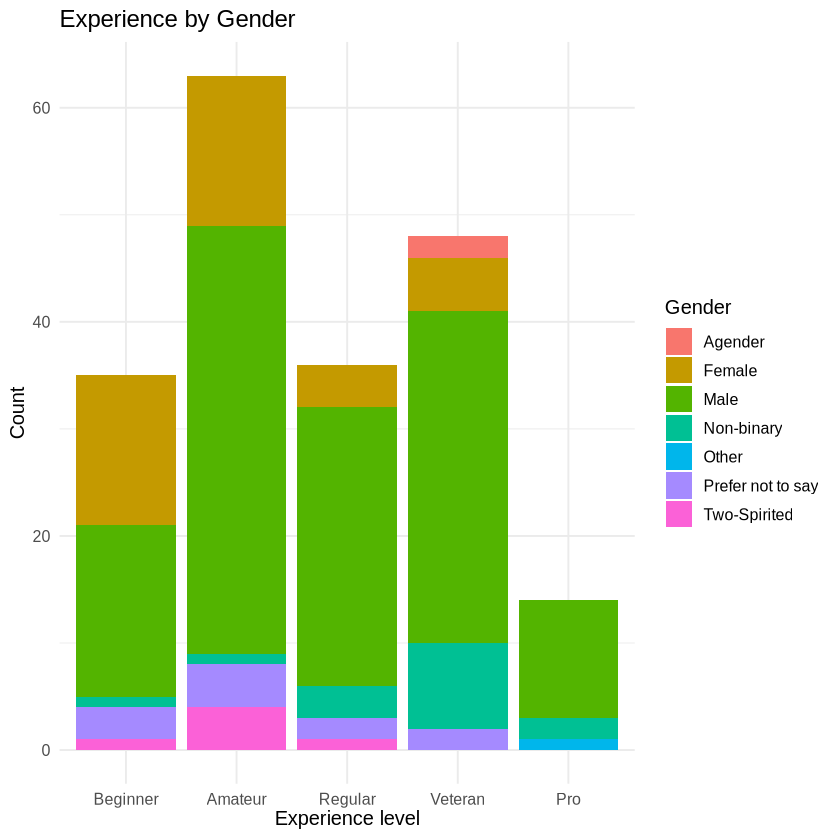

In [7]:
count_pct <- function(df, col) {
  df |>
    mutate({{ col }} := as.factor({{ col }})) |>
    count({{ col }}, name = "count") |>
    mutate(percent = round(100 * count / sum(count), 2)) |>
    arrange(desc(count))
}

experience_dist <- count_pct(players, experience)
gender_dist     <- count_pct(players, gender)

experience_dist
gender_dist

ggplot(players, aes(x = experience, fill = gender)) +
  geom_bar() +
  scale_x_discrete(limits = c("Beginner","Amateur","Regular","Veteran","Pro")) +
  labs(title = "Experience by Gender",
       x = "Experience level", y = "Count", fill = "Gender") +
  theme_minimal(base_size = 12)


### Skew & outliers
  - `played_hours` is **heavily right-skewed** with a long tail (extreme high values); the mean is not representative.
  - Implication: consider robust summaries, transformations, or winsorization in later modeling.


count,mean,sd,min,q25,median,q75,max,iqr
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,5.85,28.36,0,0,0.1,0.6,223.1,0.6


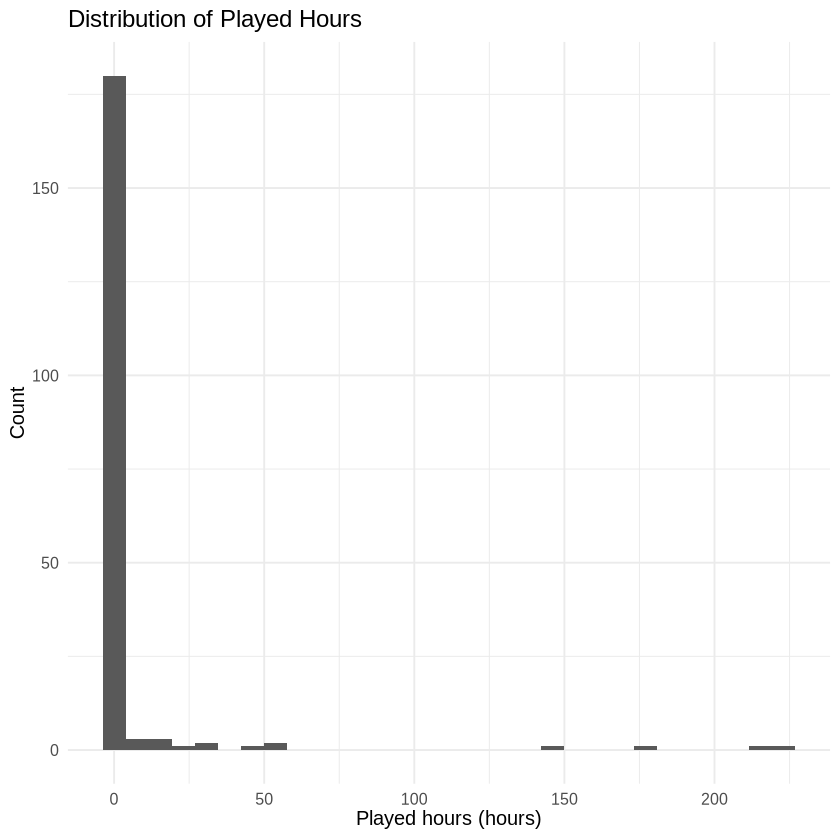

In [8]:
played_hours_summary <- players |>
  summarise(
    count  = sum(!is.na(played_hours)),
    mean   = round(mean(played_hours, na.rm = TRUE), 2),
    sd     = round(sd(played_hours,   na.rm = TRUE), 2),
    min    = round(min(played_hours,  na.rm = TRUE), 2),
    q25    = round(quantile(played_hours, 0.25, na.rm = TRUE), 2),
    median = round(median(played_hours, na.rm = TRUE), 2),
    q75    = round(quantile(played_hours, 0.75, na.rm = TRUE), 2),
    max    = round(max(played_hours,  na.rm = TRUE), 2),
    iqr    = round(IQR(played_hours,  na.rm = TRUE), 2)
  )

ggplot(players, aes(x = played_hours)) +
  geom_histogram(bins = 30) +
  labs(title = "Distribution of Played Hours",
       x = "Played hours (hours)", y = "Count") +
  theme_minimal(base_size = 12)

played_hours_summary

## Data Description: Sessions

In [9]:
library(tidyverse)
sessions <- read_csv("data/sessions.csv")

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
glimpse(sessions)

Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…


### Summary of Sessions Dataset

In [12]:
type_of <- function(x) class(x)[1]

sessions_dict <- tibble(
  variable = names(sessions),
  type     = purrr::map_chr(sessions, type_of),
  description = dplyr::case_when(
    variable == "hashedEmail"          ~ "Hashed email (join key to players)",
    variable == "start_time"           ~ "Session start time (string)",
    variable == "end_time"             ~ "Session end time (string)",
    variable == "original_start_time"  ~ "Original start timestamp (numeric)",
    variable == "original_end_time"    ~ "Original end timestamp (numeric)",
    TRUE ~ ""
  )
)

sessions_dict

variable,type,description
<chr>,<chr>,<chr>
hashedEmail,character,Hashed email (join key to players)
start_time,character,Session start time (string)
end_time,character,Session end time (string)
original_start_time,numeric,Original start timestamp (numeric)
original_end_time,numeric,Original end timestamp (numeric)


### Sessions Means
- `original_start_time` — 1.719201e+12 (mean)
- `original_end_time` — 1.719196e+12 (mean)

In [13]:
sessions_means <- sessions |>
  select(where(is.numeric)) |>
  summarise(across(everything(), ~ round(mean(.x, na.rm = TRUE), 2))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "mean_2dp")

sessions_means

variable,mean_2dp
<chr>,<dbl>
original_start_time,1.719201e+12
original_end_time,1.719196e+12


### Observation of Missing Values (sessions)
- `end_time` has **2** missing values.  
- `original_end_time` has **2** missing values.  
- Implication: rows with missing end times cannot yield a valid session duration.


In [14]:
sessions_missing <- sessions |>
  summarise(across(everything(), ~ sum(is.na(.x)))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "missing_n") |>
  arrange(desc(missing_n))

sessions_missing

variable,missing_n
<chr>,<int>
end_time,2
original_end_time,2
hashedEmail,0
start_time,0
original_start_time,0


### Skew & outliers (sessions)

- `duration_min` is computed as `(original_end_time - original_start_time) / 60`.  
- Rows with missing `original_end_time` are excluded from duration calculations.  
- We summarize distribution (2 d.p.) and plot a histogram to check right-tail behavior/outliers.


count,mean,sd,min,q25,median,q75,max,iqr
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1533,48488.8,79690.16,0,0,0,166666.7,333333.3,166666.7


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


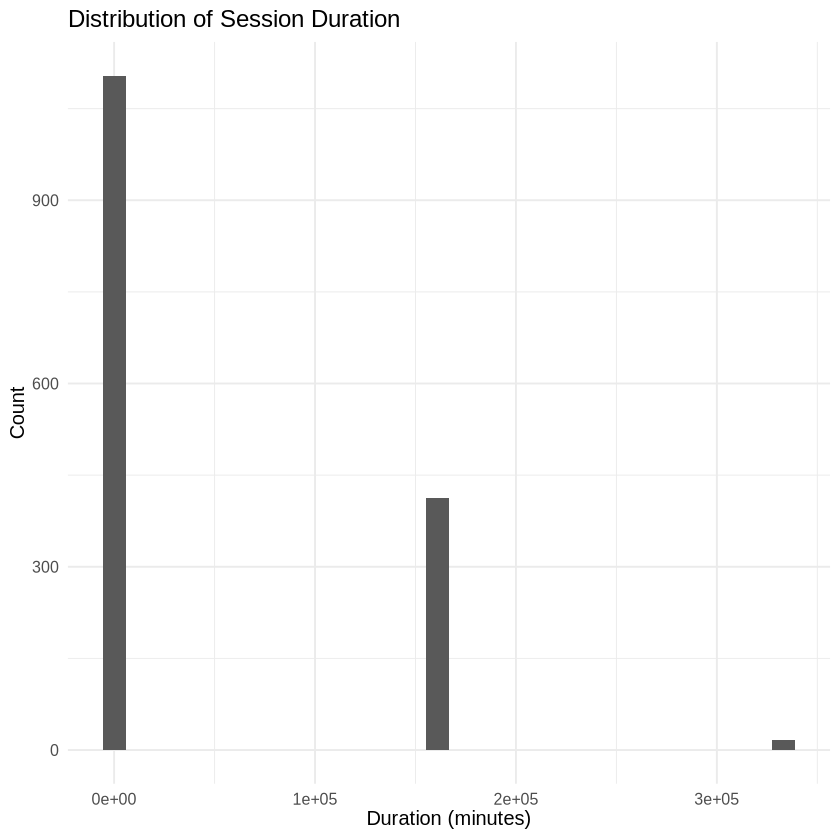

In [15]:
sessions_with_dur <- sessions |>
  mutate(duration_min = (original_end_time - original_start_time) / 60)

duration_summary <- sessions_with_dur |>
  summarise(
    count  = sum(!is.na(duration_min)),
    mean   = round(mean(duration_min, na.rm = TRUE), 2),
    sd     = round(sd(duration_min,   na.rm = TRUE), 2),
    min    = round(min(duration_min,  na.rm = TRUE), 2),
    q25    = round(quantile(duration_min, 0.25, na.rm = TRUE), 2),
    median = round(median(duration_min, na.rm = TRUE), 2),
    q75    = round(quantile(duration_min, 0.75, na.rm = TRUE), 2),
    max    = round(max(duration_min,  na.rm = TRUE), 2),
    iqr    = round(IQR(duration_min,  na.rm = TRUE), 2)
  )

duration_summary

ggplot(sessions_with_dur, aes(x = duration_min)) +
  geom_histogram(bins = 30) +
  labs(
    title = "Distribution of Session Duration",
    x = "Duration (minutes)", y = "Count"
  ) +
  theme_minimal(base_size = 12)


## Exploratory Data Analysis and Visualization
For visualize the relationship, we need to clean the data to preserve the users both in `Players` and `Sessions`.

In [16]:
players_key  <- players  |>
  mutate(hashedEmail = tolower(trimws(hashedEmail))) |>
  distinct(hashedEmail)

sessions_key <- sessions |>
  mutate(hashedEmail = tolower(trimws(hashedEmail))) |>
  distinct(hashedEmail)

both_keys <- inner_join(players_key, sessions_key, by = "hashedEmail")

players_common <- players |>
  mutate(hashedEmail = tolower(trimws(hashedEmail))) |>
  semi_join(both_keys, by = "hashedEmail")

sessions_common <- sessions |>
  mutate(hashedEmail = tolower(trimws(hashedEmail))) |>
  semi_join(both_keys, by = "hashedEmail")

tibble(
  players_before  = nrow(players),
  players_after   = nrow(players_common),
  sessions_before = nrow(sessions),
  sessions_after  = nrow(sessions_common),
  unique_players_before  = n_distinct(players$hashedEmail),
  unique_players_after   = n_distinct(players_common$hashedEmail),
  unique_sessions_before = n_distinct(sessions$hashedEmail),
  unique_sessions_after  = n_distinct(sessions_common$hashedEmail)
)

players_before,players_after,sessions_before,sessions_after,unique_players_before,unique_players_after,unique_sessions_before,unique_sessions_after
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
196,125,1535,1535,196,125,125,125


### Subscription vs Experience

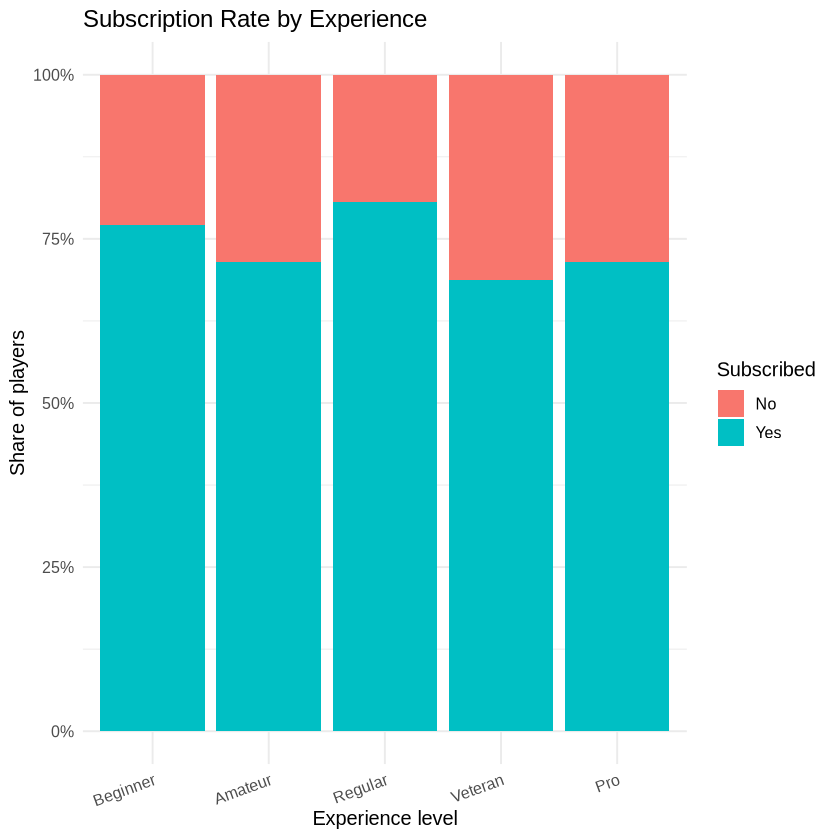

In [17]:
players_plot <- players |>

  mutate(
    subscribe_f = factor(subscribe, levels = c(FALSE, TRUE), labels = c("No", "Yes")),
    experience  = factor(experience, levels = c("Beginner","Amateur","Regular","Veteran","Pro"))
  )

ggplot(players_plot, aes(x = experience, fill = subscribe_f)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Subscription Rate by Experience",
       x = "Experience level", y = "Share of players", fill = "Subscribed") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))


### Subscription vs Gender

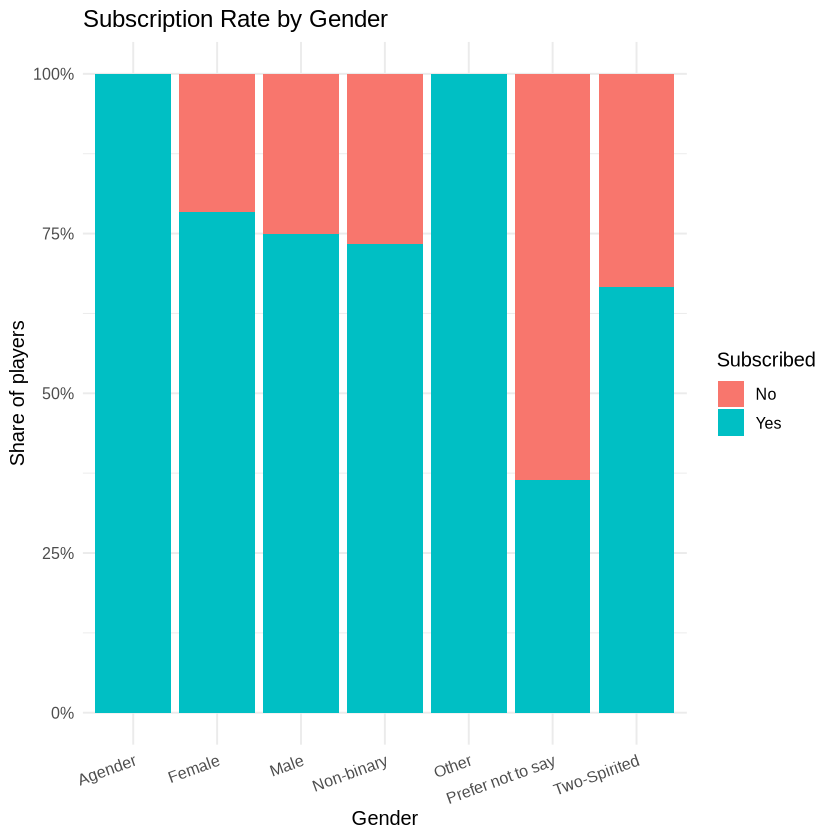

In [18]:
ggplot(players_plot, aes(x = gender, fill = subscribe_f)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Subscription Rate by Gender",
       x = "Gender", y = "Share of players", fill = "Subscribed") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))


### Subscription vs Played Hours

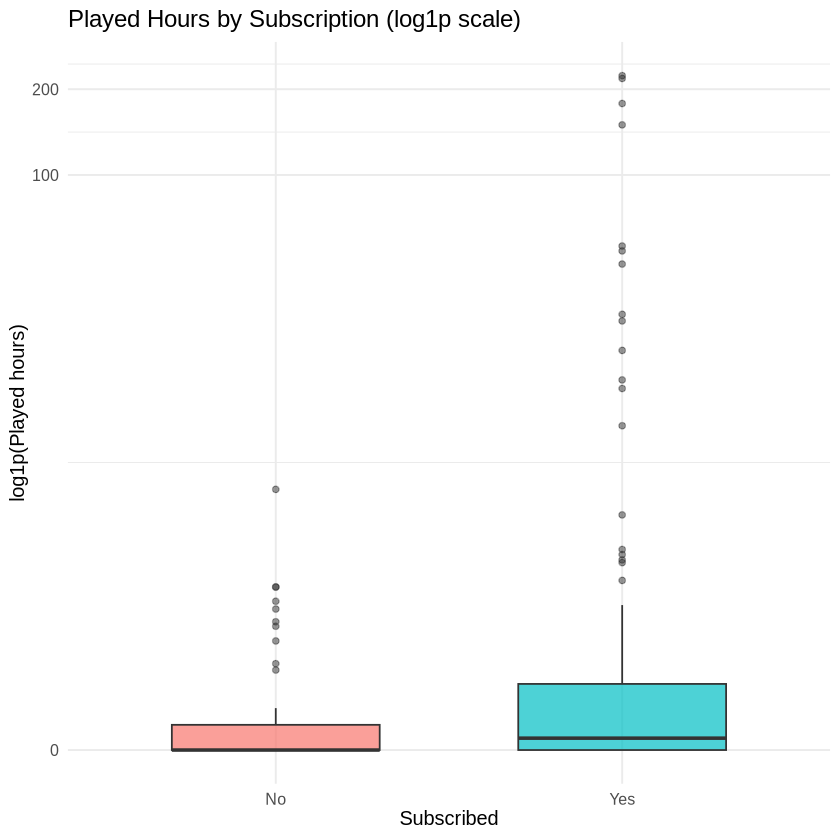

In [19]:
ggplot(players_plot, aes(x = subscribe_f, y = played_hours, fill = subscribe_f)) +
  geom_boxplot(alpha = 0.7, width = 0.6, outlier.alpha = 0.5) +
  scale_y_continuous(trans = "log1p") +
  labs(title = "Played Hours by Subscription (log1p scale)",
       x = "Subscribed", y = "log1p(Played hours)", fill = "Subscribed") +
  theme_minimal(base_size = 12) +
  theme(legend.position = "none")


### Subscription vs Age

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


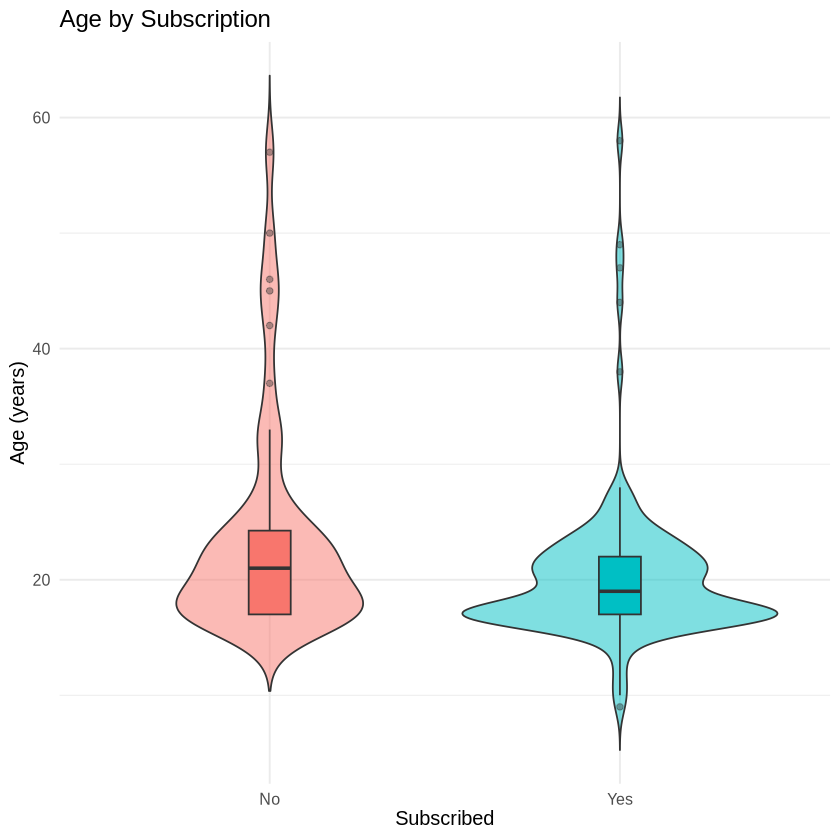

In [20]:
ggplot(players_plot, aes(x = subscribe_f, y = Age, fill = subscribe_f)) +
  geom_violin(trim = FALSE, alpha = 0.5) +
  geom_boxplot(width = 0.12, outlier.alpha = 0.4) +
  labs(title = "Age by Subscription",
       x = "Subscribed", y = "Age (years)", fill = "Subscribed") +
  theme_minimal(base_size = 12) +
  theme(legend.position = "none")


## Methods and Plan
**Chosen method:** **kNN classification** to predict `subscribe` (Yes/No) from `experience`, `played_hours`, `Age`, and `gender`.


### Why kNN is appropriate
- Our outcome is **binary** and the relationship may be **non-linear**; kNN can learn **flexible decision boundaries** without a parametric form.
- With a **small feature set** and mixed types (numeric + categorical after encoding), kNN is simple and transparent.

### Assumptions
- **Local similarity:** players with similar features tend to share subscription status.
- **Meaningful distance:** after **scaling** numeric features and **encoding** categoricals, Euclidean distance reflects similarity.
  


### Potential limitations
- **Scale sensitivity:** must standardize numeric features (`played_hours`, `Age`); otherwise distance is dominated by large-scale variables.
- **Curse of dimensionality / irrelevant features:** performance degrades if noisy features are included; keep features minimal and relevant.
- **Class imbalance:** majority class can dominate neighbor votes; monitor PR-AUC and consider threshold tuning.


### Model comparison & selection
- Use **stratified 5-fold cross-validation on the training set** to choose **k** from a small grid.


### Data processing plan

- **Split once (stratified):** 75% train / 25% test by `subscribe`.
- **On the training set only:**
  - **Impute `Age`** .
  - **log1p transform** `played_hours` if very skewed.
  - **Standardize numeric** features (`Age`, `played_hours`) to mean 0, sd 1.
- **Model selection:** 5-fold CV on the training set to choose **k** from {3, 5, 7, 9, 15}.
- **Final evaluation:** retrain with chosen preprocessing + k on full training data; **evaluate once** on the held-out test set.
